In [152]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn import metrics

In [135]:
diamonds = sns.load_dataset('diamonds')
X = diamonds[["carat", "depth", "table", "x", "y", "z"]]
y = diamonds["price"]

In [136]:
X.sample(5)

,carat,depth,table,x,y,z
19866,2.68,58.6,60.0,9.11,9.07,5.33
20322,1.50,63.3,57.0,7.20,7.24,4.57
32981,0.37,61.2,57.0,4.58,4.64,2.82
38757,0.51,63.5,60.0,5.03,5.05,3.20
17730,1.01,62.4,61.0,6.34,6.38,3.97


In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## Ridge Regression
Ridge regression is a form of regularized linear regression. It penalizes large parameters (in order to avoid overfitting). For Ridge regression, the metric by which the parameters' **size** is determined, is the L2 norm, it is hence also called L2-Regression (aka Tikhonov regularization). If the L1 norm is used, it's called L1-regression or Lasso Regression.
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

Ridge() takes as an argument the weight alpha of the parameters' size. If the weight is zero, it's regular linear regression. If the weight is very high, parameters will be forced towards zero.

In [138]:
ridge = Ridge(normalize=True)

To find the right alpha, we would like to try different values. We can't use the test set, however, as this would constitute data leakage (using information from the test set to train our hyperparameter, alpha). Instead, we are splitting the test set **again**. We are doing so systematically, using - here - 5 folds. That means, for each parameter choice, 5 models are trained and tested on one remaining fifth of the training set to then choose the best parameter.

We are using GridSearchCV, which automatically finds the best parameter based on the cross-validation.

In [139]:
parameters = {"alpha": np.arange(0,10)/100}
grid = GridSearchCV(ridge, parameters, cv=5, verbose=True, 
                    scoring="neg_root_mean_squared_error") # Scoring is maximized, hence "neg"

In [140]:
grid.fit(X_train, y_train.values)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=True, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_root_mean_squared_error', verbose=True)

In [141]:
pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["Score"], index=list(parameters.values()))

,Score
0.00,-1506.598655
0.01,-1514.628057
0.02,-1535.929878
0.03,-1556.036735
0.04,-1573.758734
0.05,-1589.113509
0.06,-1602.411585
0.07,-1613.993759
0.08,-1624.161053
0.09,-1633.162518


Looks like good old linear regression works best! Now we have decided for a hyperparameter and can actually predict our test set.

In [142]:
y_pred = grid.predict(X_test)

In [144]:
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred))

RMSE:  1491.7232698830483
MAE:  888.0406743117745


Our test score is very similar to the validation score. That's a good sign!

### Advanced Model
Now let's bring cross validation together with a powerful technique we talked about before: Pipelines. We are creating a Pipeline of different steps and tune their parameters using a grid search - hopefully ending up with a strong model.

We are first using a robust scaling and after that, we are creating polynomial features (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html). This model is fed into a Lasso regression (i.e., linear regression with L1 norm regularization)

We are here varying polynomial degree and the Lasso regression's alpha!

In [153]:
rs = RobustScaler()
poly = PolynomialFeatures()
lasso = Lasso()

pipe = Pipeline([
    ("poly", poly),
    ("robust", rs),
    ("lasso", lasso)
])

# Use estimator's give name with a double underscore to set parameters!
param_grid = {
    'poly__degree': [1, 2, 3],
    'lasso__alpha': np.linspace(0, 1, 5), # 0.0, 0.25, 0.5, 0.75, 1
}

In [154]:
grid = GridSearchCV(pipe, param_grid, cv=5, verbose=True, n_jobs=4,
                    scoring="neg_root_mean_squared_error")

Watch out, this takes a while! By creating polynomial features, the number of dimensions increses drastically!

In [155]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:  2.2min finished
/Users/kienscherfp/opt/miniconda3/envs/PDS20/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25557992341.30397, tolerance: 68900305.6252063
  positive)


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('poly',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('robust',
                                        RobustScaler(copy=True,
                                                     quantile_range=(25.0,
                                                                     75.0),
                                                     with_centering=True,
                                                     with_scaling=True)),
                                       ('lasso',
                                        Lasso(alpha=1.0, copy_X=True,
                                     

In [212]:
grid_df = pd.DataFrame(grid.cv_results_["params"])
grid_df["loss"] = -grid.cv_results_['mean_test_score']
grid_df

,lasso__alpha,poly__degree,loss
0,0.00,1,1506.321220
1,0.00,2,1737.621851
2,0.00,3,2906.300634
3,0.25,1,1504.230116
4,0.25,2,1562.461292
5,0.25,3,2144.553216
6,0.50,1,1502.578297
7,0.50,2,1485.241924
8,0.50,3,2017.954794
9,0.75,1,1501.370065


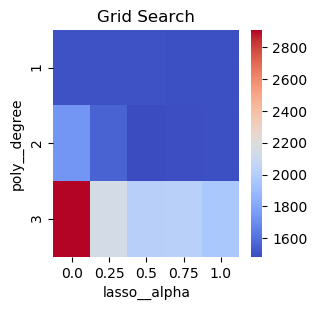

In [219]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=100)
sns.heatmap(grid_df.pivot(columns="lasso__alpha", values="loss", index="poly__degree"), cmap="coolwarm", ax=ax)
ax.set_title("Grid Search")

plt.show()

In [156]:
grid.best_params_

{'lasso__alpha': 0.5, 'poly__degree': 2}

In [157]:
y_pred = grid.predict(X_test)

In [158]:
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred))

RMSE:  1428.6156960103754
MAE:  835.2205459703711
